## Description of the project:

   In this part of the class, we will curate a set of **CO2 measurements**, measured from cheap but inaccurate sensors, that have been deployed in the city of Zurich. The goal of the exercise is twofold: 

1. Learn how to deal with real world sensor timeseries data, and organize them efficiently using python dataframes.

2. Apply data science tools to model the measurements, and use the learned model to process them (e.g., detect outliers and drifts in the sensor measurements). 

The sensor network consists of 46 sites, located in different parts of the city. Each site contains three different sensors measuring (a) **CO2 concentration**, (b) **temperature**, and (c) **humidity**. Beside these measurements, we have the following additional information that can be used to process the measurements: 


1. The average **daily wind pattern** for the city of Zurich 

2. The **altitude** at which the CO2 sensor is located

3. A clustering of the city of Zurich in 17 different zones and the **city zone** in which the sensor belongs to. Some characteristic zones are industrial area, residential area, forest, glacier, lake, etc.

Given this knowledge, you are asked to define a machine learning algorithm that curates the data, by detecting potential outliers or drifts. The algorithm should be based on the fact that sensors in similar conditions are expected to have similar measurements.

## Prior knowledge:
    
The average value of the CO2 in a city is approximately 400 ppm. However, the exact measurement in each site depends on parameters such as the temperature, the humidity, the wind, the altitude, and the level of traffic around the site. For example, sensors positioned in high altitude (mountains) and exposed to stronger winds, are expected to have a much lower and uniform level of CO2 than sensors that are positioned in a business area with much higher traffic activity. Moreover, we know that there is a strong dependence of the CO2 measurements, on temperature and humidity.



## Goal:
    
  We would like to use the above knowledge in order to fit a robust regression model to the CO2 measurements. This model should be built by processing the measurements of the entire sensor network jointly, and it should take into account the dependence on the above mentioned parameters. Finally, the learned model will be used to curate the CO2 measurements by detecting possible outliers and drifts. 

**Note:**
Different machine learning approaches can be used to solve the problem. For simplicity, we provide a suggested approach, and the corresponding steps that can guide your solution. 


### Imports

Import the following python packages: pandas, datetime, matplotlib, numpy, sklearn

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import sklearn
import array

### To start with: 

The following csv files will be needed: 

- `CO2_sensor_measurements.csv`

Description: It containts the CO2 measurements (CO2), the name of the site (LocationName), a unique sensor identifier (SensorUnit_ID), and the time instance in which the measurement was taken (timestamp).
    
- `temperature_humidity.csv`

Description: It contains the temperature and the humidity measurements for each sensor identifier, at each timestamp (Timestamp). For each SensorUnit_ID, the temperature and the humidity can be found in the corresponding columns of the dataframe (SensorUnit_ID.temperature, SensorUnit_ID.humidity).
    
- `sensor_metadata.csv`

Description: It contains the name of the site (LocationName), the zone index (zone), and the altitude in meters. 
    
- `zurich_average_wind.csv`

Description: It contains the average wind speed (wind_speed) in the city of Zurich measured every 30 minutes (timestamp).

In [2]:
CO2_measurement = pd.read_csv('CO2_sensor_measurements.csv', sep='\t')
zurich_average_wind = pd.read_csv('zurich_average_wind.csv', sep='\t',parse_dates=['timestamp'],index_col='timestamp')
zurich_temp_humidity= pd.read_csv('temperature_humidity.csv', sep='\t')
sensors_metadata = pd.read_csv('sensors_metadata.csv', sep='\t') 

In [3]:
zurich_average_wind.head()


,wind_speed
timestamp,
2017-10-01 00:00:00,2.330000
2017-10-01 00:30:00,1.480000
2017-10-01 01:00:00,0.950000
2017-10-01 01:30:00,0.923333
2017-10-01 02:00:00,0.776667



## PART I: Handling time series with pandas (15 points)

### Question I.a. (12/15)

Organize the CO2_sensor_measurements.csv and temperature_humidity.csv files into a single dataframe that contains as index the time instance (timestamp) of the measurements, and columns the location of the site (LocationName), the sensor ID (SensorUnit_ID), the CO2 measurement, the temperature, and the humidity. For each measurement (CO2, humidity, temperature), take the average over an interval of 30 min. If there are missing measurements, interpolate them linearly from measurements that are close by in time.

Hints: the following methods could be useful:

- [pandas.DataFrame.resample()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html)
    
- [pandas.DataFrame.interpolate()](https://pandas.pydata.org/pandasdocs/stable/generated/pandas.DataFrame.interpolate.html)

- [pandas.DataFrame.mean()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.mean.html)

- [pandas.DataFrame.append()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.append.html)

In [4]:
CO2_measurement.head()


,timestamp,LocationName,SensorUnit_ID,CO2
0,2017-10-01 00:05:00,ZGHD,1014,593.321562
1,2017-10-01 00:15:00,ZGHD,1014,595.846258
2,2017-10-01 00:25:00,ZGHD,1014,595.845353
3,2017-10-01 00:45:00,ZGHD,1014,599.039129
4,2017-10-01 00:55:00,ZGHD,1014,594.996629


Hint: Your dataframe should look like that

In [5]:
CO2_measurement[CO2_measurement.isnull().any(axis=1)]#No raws with empty cells

,timestamp,LocationName,SensorUnit_ID,CO2


zurich_temp_humidity dataset has NaN values that we need to interpolate. We also resample with 30min time intervals.

In [6]:
zu_temp_hum=zurich_temp_humidity.copy()
zu_temp_hum['Timestamp']=pd.to_datetime(zu_temp_hum['Timestamp'])
zu_temp_hum=zu_temp_hum.interpolate('linear').resample(rule='30Min', on='Timestamp').mean()

In [7]:
CO2=CO2_measurement.copy()
CO2['timestamp']=pd.to_datetime(CO2['timestamp'])
CO2=CO2.groupby('LocationName').resample(rule='30Min', on='timestamp').reset_index(level='LocationName')

/Users/Hippo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 
.resample() is now a deferred operation
You called reset_index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
Final=CO2.copy()

We add two empty columns "temperature" and "humidity":

In [9]:
Final["temperature"] = np.nan
Final["humidity"] = np.nan

And we create a dictionnary of location:sensorID:

In [10]:
dict={}#Dictionnary of location:ID
for loc  in Final['LocationName'].unique():
    df=Final[Final['LocationName']==loc]
    for ID in df ['SensorUnit_ID']:
            if float(ID)>1000:
                val=ID
                dict[loc]=val
                break
    

And we use this dictionnary to fill missing sensorID's:

In [11]:
for row in range(len(Final)):#Deal with sensorID=NaN. Match with location
    Final.iloc[row,1]=dict[Final.iloc[row,0]]

In [12]:
Final=Final.sort_values(by=['SensorUnit_ID'],kind='mergeshort').interpolate('linear')#Order by increasing sensor id

In [13]:
Final.head()

,LocationName,SensorUnit_ID,CO2,temperature,humidity
timestamp,,,,,
2017-10-01 00:00:00,ZGHD,1014.0,595.004391,NaN,NaN
2017-10-01 00:30:00,ZGHD,1014.0,597.017879,NaN,NaN
2017-10-01 01:00:00,ZGHD,1014.0,596.487010,NaN,NaN
2017-10-01 01:30:00,ZGHD,1014.0,598.787639,NaN,NaN
2017-10-01 02:00:00,ZGHD,1014.0,595.366394,NaN,NaN


Now we need to check that the two datasets ("Final" above and zu_temp_hum) have the same sensorID ordering to be able to merge them after:

In [14]:
colsfi=Final['SensorUnit_ID'].unique()#Get an array of all sensor id orderer
colszu=[]
for cols in zu_temp_hum:#Get an array of all sensor id by order in the second dataset
    idx=float(cols[:4])
    if idx in colszu:
        continue
    colszu.append(idx)
    

In [15]:
list(colszu)==list(colsfi)###Check if the order is the same and if all the values match

True

Now we copy temperature and humidity columns from "zu_temp_hum" into CO2 (Final) dataset:

In [16]:
for cols in zu_temp_hum:#Then we can copy temperature and humidity columns into CO2 dataset
    idx=float(cols[:4])
    if cols[-4:]=='ture':
        Final.loc[Final["SensorUnit_ID"]==idx,'temperature']=zu_temp_hum[cols]
    else:
        Final.loc[Final["SensorUnit_ID"]==idx,'humidity']=zu_temp_hum[cols]

In [17]:
Final.head()

,LocationName,SensorUnit_ID,CO2,temperature,humidity
timestamp,,,,,
2017-10-01 00:00:00,ZGHD,1014.0,595.004391,11.396667,92.440806
2017-10-01 00:30:00,ZGHD,1014.0,597.017879,11.303333,91.625097
2017-10-01 01:00:00,ZGHD,1014.0,596.487010,11.240000,91.096761
2017-10-01 01:30:00,ZGHD,1014.0,598.787639,11.260000,91.275734
2017-10-01 02:00:00,ZGHD,1014.0,595.366394,11.285000,91.003937


### And we get our expected dataset !

In [18]:
Final[Final.isnull().any(axis=1)]#We check that there is no NaN values

,LocationName,SensorUnit_ID,CO2,temperature,humidity
timestamp,,,,,


### Question I.b. (3/15)

Export the curated and ready to use timeseries to a csv file. 

In [19]:
 Final.to_csv('Dataset_C02_hum_temp.csv')#Export in current folder

## PART II: Finding meaningful structures/patterns in the data (20 points)

### Question II.a. (3/30)

Plot the daily median CO2 measurement for each site with respect to the altitude. Annotate each point of the plot with the name of the location (LocatioName).

In [20]:
New=Final.copy()#We make a copy of the previously built dataset
New.head()

,LocationName,SensorUnit_ID,CO2,temperature,humidity
timestamp,,,,,
2017-10-01 00:00:00,ZGHD,1014.0,595.004391,11.396667,92.440806
2017-10-01 00:30:00,ZGHD,1014.0,597.017879,11.303333,91.625097
2017-10-01 01:00:00,ZGHD,1014.0,596.487010,11.240000,91.096761
2017-10-01 01:30:00,ZGHD,1014.0,598.787639,11.260000,91.275734
2017-10-01 02:00:00,ZGHD,1014.0,595.366394,11.285000,91.003937


Now let's resample on days:

In [21]:
New['Timestamp']=New.index
Med=New.groupby('LocationName').resample(rule='1D', on='Timestamp').reset_index(level='LocationName')

/Users/Hippo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 
.resample() is now a deferred operation
You called reset_index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  


And we look for the median C02 for all locations:

In [22]:
Median_daily=Med.groupby('LocationName',as_index=False)['CO2'].median()

In [23]:
Median_daily.head()

,LocationName,CO2
0,AJGR,335.531220
1,BSCR,497.800065
2,BUDF,433.879124
3,KBRL,413.372222
4,KTGM,445.540946


Let's plot daily median CO2 measurement for each site with respect to the altitude:

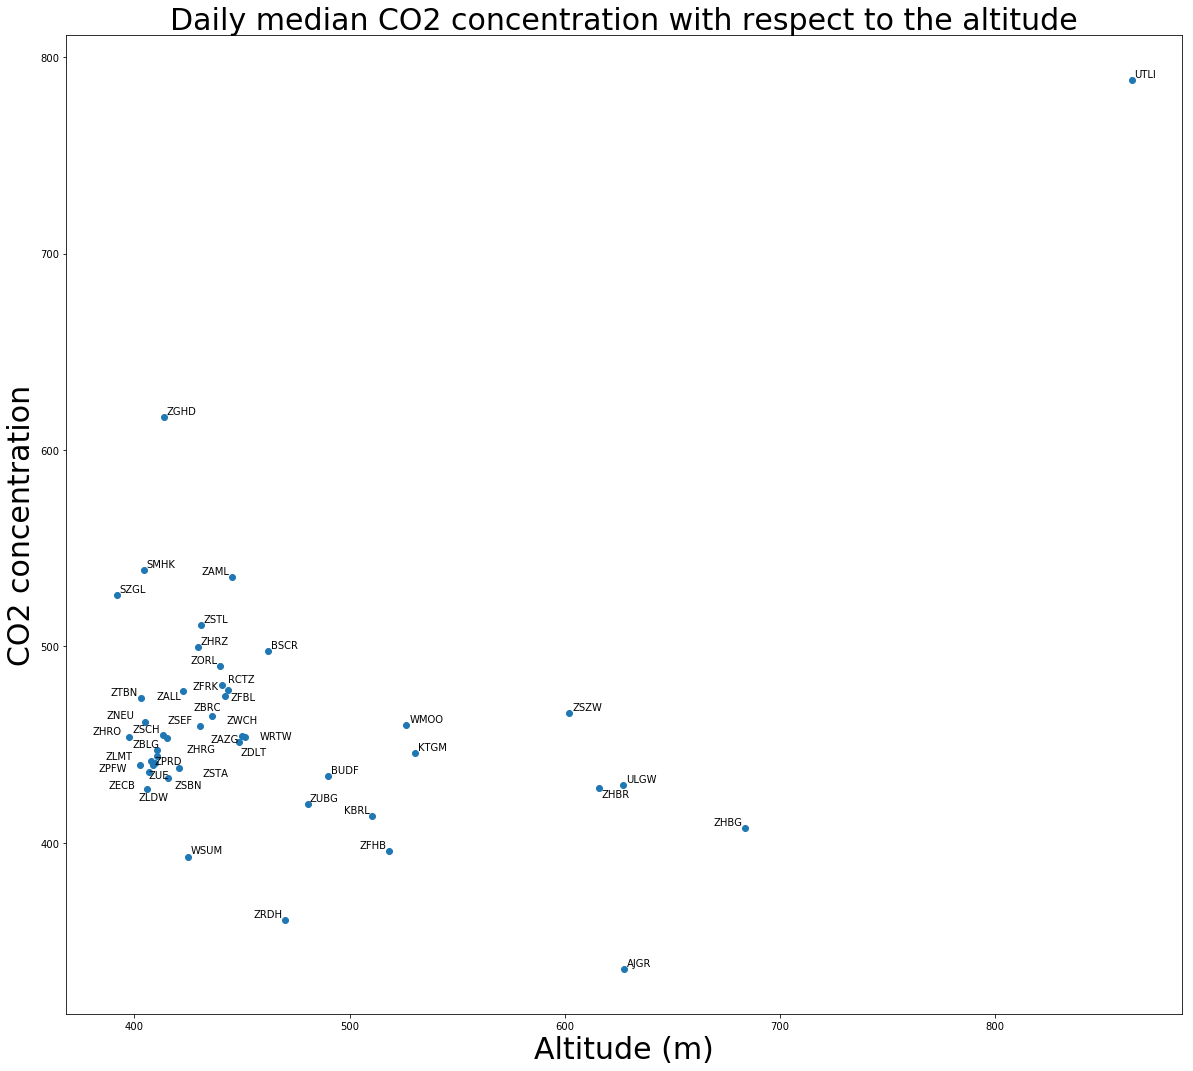

In [24]:
from adjustText import adjust_text # Interesting opensource library to separate overlapped scatter labels


x=list(sensors_metadata['altitude'])
y=list(Median_daily['CO2'])
z=list(sensors_metadata['LocationName'])
texts=[]

fig, ax = plt.subplots(figsize=(20,18))

plt.scatter(x,y)
for x1, y1, z1 in zip(x, y, z):
    texts.append(plt.text(x1, y1, z1))



#for i, txt in enumerate(z]):
   # ax.annotate(txt, (x[i],y[i]),horizontalalignment='right')
    
ax.set_xlabel('Altitude (m)',fontsize=30)
ax.set_ylabel('CO2 concentration',fontsize=30)
ax.set_title('Daily median CO2 concentration with respect to the altitude',fontsize=30)

adjust_text(texts)
plt.show()

From this scatter plot we notice :
    - a large outlier (UTLI location) which has the highest altitude and the highest CO2 which seems logical
    - an other outlier on the CO2 (ZGHD) which has a low altitude yet
    - rest of points are rather homogenous and we can't really distinguish visually relationship between altitude 
    and CO2
    

### Question II.b. (7/20)

**Altitude clustering:** Cluster the sites based on their altitude, by performing a K-means clustering. Set the number of clusters to 4. 

The idea here is to simply assign each location to a cluster depending on its altitude:

In [25]:
from sklearn.cluster import KMeans
X=sensors_metadata[['altitude']]
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

In [26]:
print(kmeans.cluster_centers_) #Cluster values

[[ 421.184375]
 [ 498.6     ]
 [ 863.6     ]
 [ 631.36    ]]


In [27]:
print(kmeans.labels_) #Labels assigned by kmeans algorithm

[3 1 1 1 1 0 0 0 3 2 1 0 0 0 0 0 0 0 0 0 0 1 0 0 3 3 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 3 0 1 0 0]


We can reuse our above plotting to visualize the cluster:

Let's add the column of predicted labels:

In [82]:
Xclust=sensors_metadata.copy()
Xclust['ClustLab']=kmeans.labels_

And now observe the daily median CO2 concentration with respect to the altitude clustered:

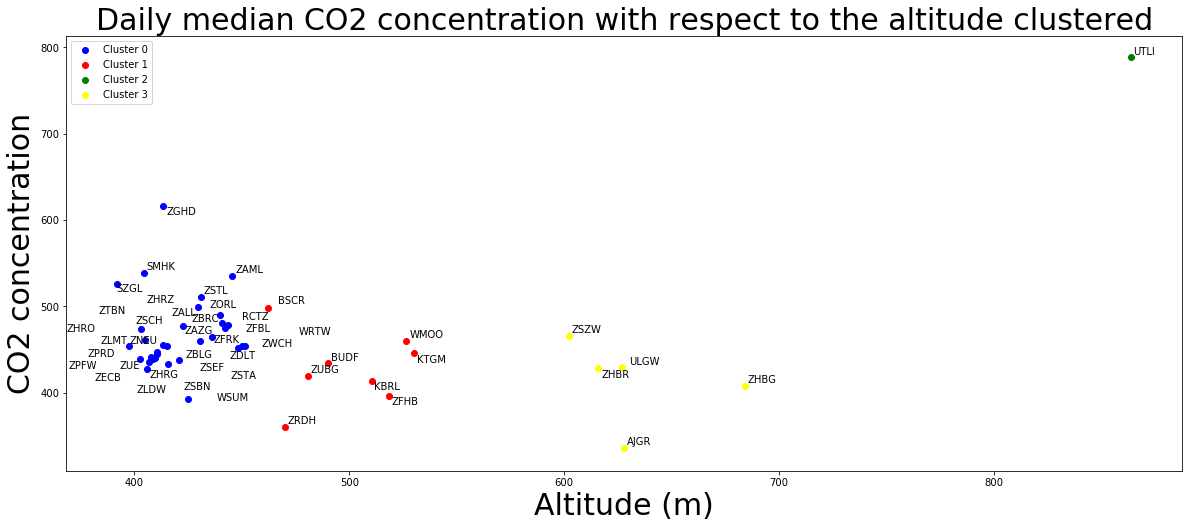

In [84]:
fig, ax = plt.subplots(figsize=(20,8))

#Here we plot each cluster
for i in range(0,4):
    X=Xclust[Xclust['ClustLab']==i]
    x=list(X['altitude'])
    y=list(Median_daily.iloc[X.index]['CO2'])
    z=list(X['LocationName'])
    
    if i==0:
        plt.scatter(x,y, c='blue',label='Cluster 0')
    if i==1:
        plt.scatter(x,y, c='red',label='Cluster 1')
    if i==2:
        plt.scatter(x,y, c='green',label='Cluster 2')
    if i==3:
        plt.scatter(x,y, c='yellow',label='Cluster 3')

#Here we create our list of sensors names
texts=[]  
x=list(Xclust['altitude'])
y=list(Median_daily['CO2'])
z=list(Xclust['LocationName']) 

for x1, y1, z1 in zip(x, y, z):
        texts.append(plt.text(x1, y1, z1))#We annotate each scatter with its sensor name
        
ax.set_xlabel('Altitude (m)',fontsize=30)
ax.set_ylabel('CO2 concentration',fontsize=30)
ax.set_title('Daily median CO2 concentration with respect to the altitude clustered',fontsize=30)

adjust_text(texts)#We use the library to separate all names to visualize them
plt.legend()# We plot the legend
plt.show()

Let's build a small function to print locations belonging to a cluster:

In [86]:
def get_loc_alt_by_clust(cluster_number,kmeans):
    cluster_map = sensors_metadata.copy().drop(['zone'],axis=1)
    cluster_map['cluster'] = kmeans.labels_
    print(cluster_map[cluster_map.cluster == cluster_number])##Altitudes for cluster 

In [89]:
get_loc_alt_by_clust(1,kmeans)#Get altitudes (and loc) in the requested

   LocationName  altitude  cluster
1          BSCR     462.3        1
2          BUDF     490.2        1
3          KBRL     510.5        1
4          KTGM     530.3        1
10         WMOO     526.3        1
21         ZFHB     518.5        1
35         ZRDH     470.0        1
43         ZUBG     480.7        1


In [32]:
clust = sensors_metadata.copy()
clust['alt_c'] = kmeans.labels_

### Question II.c. (7/20)

**Temporal clustering:** Cluster the days of the month based on the average wind conditions of the city of Zurich. 

First, resample the daily wind signal by computing the mean over an interval of 30 min. 

Then, consider each day as a 48-dimensional sample (30 min intervals per day). Perform a principle component analysis of the wind values to reduce the dimension to 2.  
Hint: You can use `pandas.DataFrame.grouby()` and `for` to generate the daily sample ([documentation](https://pandas.pydata.org/pandas-docs/stable/groupby.html#iterating-through-groups)).

Finally, apply K-means to the first two PCA coefficients. Set the number of clusters to 6.

Let's resample the daily wind signal by computing the mean over an interval of 30 min:

In [66]:
zr = zurich_average_wind.resample('30min').mean()

zr=zr.reset_index()

zr1=zr.copy()
zr['time'] = zr.timestamp.dt.time
zr['day']= zr.timestamp.dt.day
zr=zr.pivot(index='day',columns='time',values='wind_speed')

In [67]:
zr.head()#We get the expected dataframe with days on rows and 48 parameters which are the 30min intervals

time,00:00:00,00:30:00,01:00:00,01:30:00,02:00:00,02:30:00,03:00:00,03:30:00,04:00:00,04:30:00,...,19:00:00,19:30:00,20:00:00,20:30:00,21:00:00,21:30:00,22:00:00,22:30:00,23:00:00,23:30:00
day,,,,,,,,,,,,,,,,,,,,,
1,2.330000,1.480000,0.950000,0.923333,0.776667,0.513333,1.380000,1.170000,0.716667,0.436667,...,0.710000,0.656667,1.116667,0.180000,0.156667,0.133333,0.510000,0.190000,0.733333,0.570000
2,0.590000,0.673333,0.566667,0.026667,0.293333,0.606667,0.763333,0.316667,0.276667,0.470000,...,2.070000,3.203333,2.413333,1.916667,2.510000,1.766667,1.770000,3.420000,2.700000,2.426667
3,2.863333,4.593333,4.746667,4.730000,3.673333,3.350000,3.760000,5.156667,5.776667,6.090000,...,0.256667,0.400000,0.723333,0.603333,0.156667,0.510000,0.820000,1.586667,1.706667,1.043333
4,0.660000,0.480000,0.673333,0.466667,0.506667,0.576667,0.570000,0.323333,0.526667,0.523333,...,0.543333,0.400000,0.633333,0.616667,0.260000,0.400000,0.916667,0.173333,0.533333,0.556667
5,0.276667,0.343333,0.386667,0.670000,1.093333,0.750000,0.566667,0.776667,0.863333,0.126667,...,5.936667,5.376667,5.183333,3.596667,1.640000,1.336667,0.593333,3.666667,3.543333,0.350000


We standardize values before PCA:

In [68]:
from sklearn.preprocessing import StandardScaler
x = zr.loc[:].values
x = StandardScaler().fit_transform(x)

And we perform a PCA-2:

In [69]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf.head()

,principal component 1,principal component 2
0,-3.339640,-1.173835
1,0.138733,3.696964
2,5.416281,-6.199983
3,-2.044605,-0.108640
4,6.627154,7.029227


We obtain for each day the projection on the two principal components:

In [70]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6)
kmeans.fit(principalDf)
y_kmeans = kmeans.predict(principalDf)

In [71]:
print(kmeans.cluster_centers_) #Kmeans cluster position under 2 principal components
print(kmeans.labels_) 


[[ -1.25673091   2.27031094]
 [ 13.4119399   -1.24239884]
 [  4.31970605   6.80874617]
 [  4.8247933   -6.07932959]
 [  1.20916912   0.1113287 ]
 [ -3.77217141  -0.82145154]]
[5 0 3 5 2 4 0 3 5 0 0 4 5 5 5 5 5 5 5 0 2 1 3 5 5 5 4 2 1 4 5]


In [72]:
clust_wind = kmeans.labels_
sr = pd.Series(data=clust_wind,index=zr.index)
sr.head()

day
1    5
2    0
3    3
4    5
5    2
dtype: int32

With a small function, it becomes very easy to see which days belongs to which cluster.

### Question II.d. (3/20)

Choose one of the wind clusters, and plot the average wind of the days corresponding to that cluster. 

We define the following function that plots the average wind of the days corresponding to a cluster:

In [73]:
def av_winds_cluster_plot(cluster_number,full=False):
    
    #Prepare the data to be plotted
    df = principalDf.copy()
    df['cluster'] = kmeans.labels_
    df['mean_wind']=zr.reset_index().mean(axis=1)
    
    plt.close('all')
    fig, ax = plt.subplots(figsize=(20,15))
    
    #Plot only for one cluster or all ? Parameter full
    if (full == False):
        df=df[df.cluster == cluster_number]
        plt.scatter(df.index,df['mean_wind'])
    
    else:
        plt.scatter(df.index+1,df['mean_wind'],c=kmeans.labels_, cmap='rainbow')
        
    #Here we plot the value for each scatter    
    x=list(df.index)
    y=list(df['mean_wind'])
    z=list(df['mean_wind'])
    texts=[]
   
    for x1, y1,z1 in zip(x, y,z):
        texts.append(plt.text(x1, y1,z1))
    
    ####
    
    ax.set_xlabel('Day of the month (from 2017-10-01 to 2017-10-31 )',fontsize=30)
    ax.set_ylabel('Average daily wind',fontsize=30)
    ax.set_title('Average wind of the days corresponding to the %i th cluster'% cluster_number,fontsize=30)
    ax.set_xticks(range(1,32,1))
  
    #adjust_text(texts)
    plt.show()

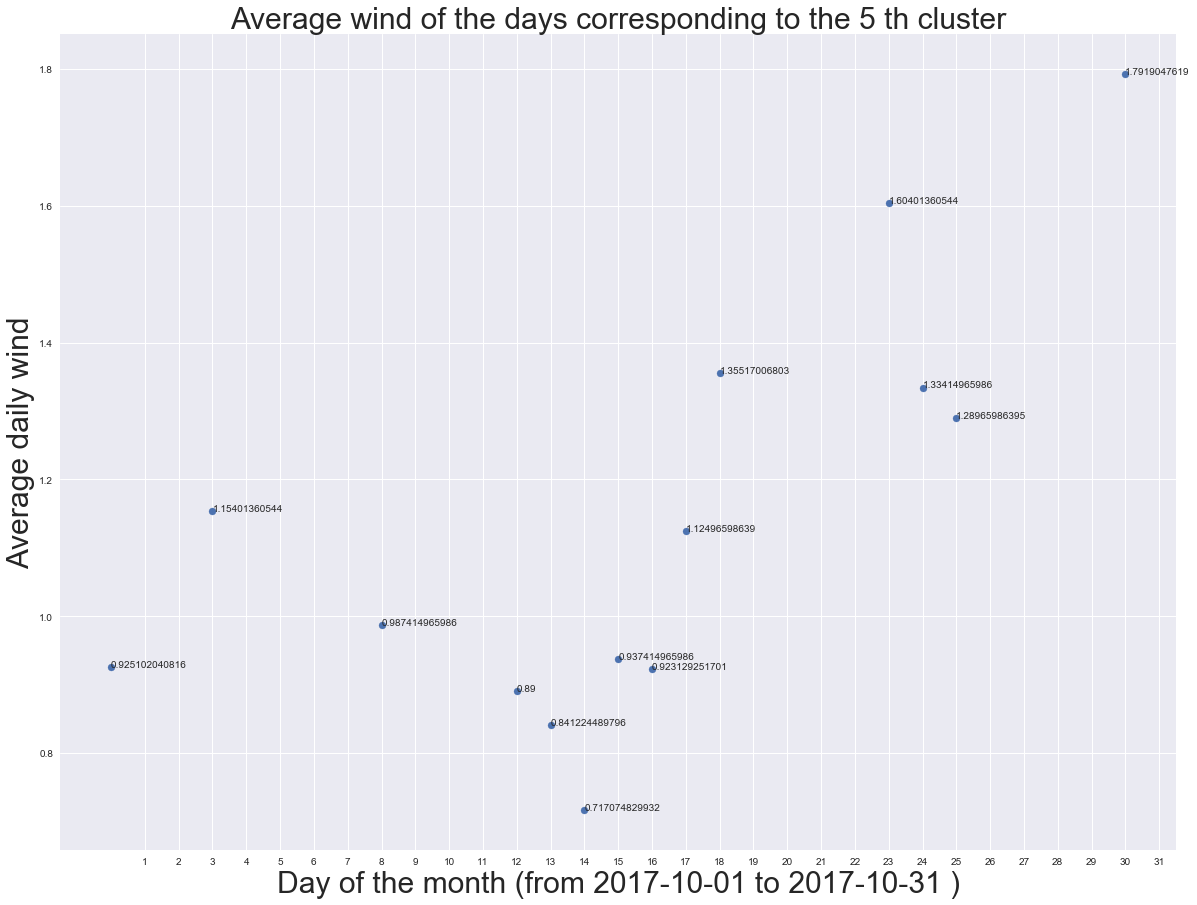

In [75]:
av_winds_cluster_plot(5,full=False)

## PART III: Model fitting for outlier detection (15 points)


### Question III.a.(5/15)

A domain expert indicates that there is problem with the `ZSBN` sensor, which appears after October 24. You decide to fit a linear model to the CO2 measurements of the site, by considering as features the temperature and the humidity. Plot and compare the actual CO2 measurements, and the values obtained by the prediction of the linear model for the entire month of October. Can you guess the problem from your plot?

In [76]:
x = Final[Final['LocationName']=='ZSBN']
Z = x[['temperature','humidity','CO2']]
X = x[['temperature','humidity']]
Y = x['CO2']

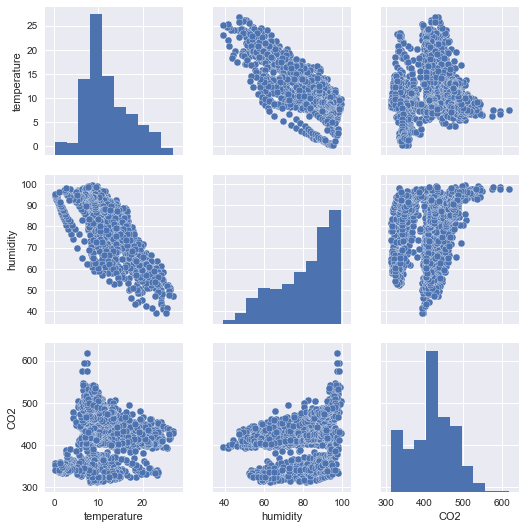

In [77]:
import seaborn as sb
%matplotlib inline
sb.pairplot(Z);

In [78]:
Z.corr()

,temperature,humidity,CO2
temperature,1.000000,-0.793688,-0.021642
humidity,-0.793688,1.000000,0.381827
CO2,-0.021642,0.381827,1.000000


In [79]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
#X_train,X_test,Y_train,Y_test = train_test_split(X,Y,random_state=1)
linreg  = LinearRegression()
linreg.fit(X,Y)
y_pred = linreg.predict(X)
print(np.sqrt(metrics.mean_squared_error(Y,y_pred)))

43.160982066


Wee notice that predictions are overevaluated compared to actuals.

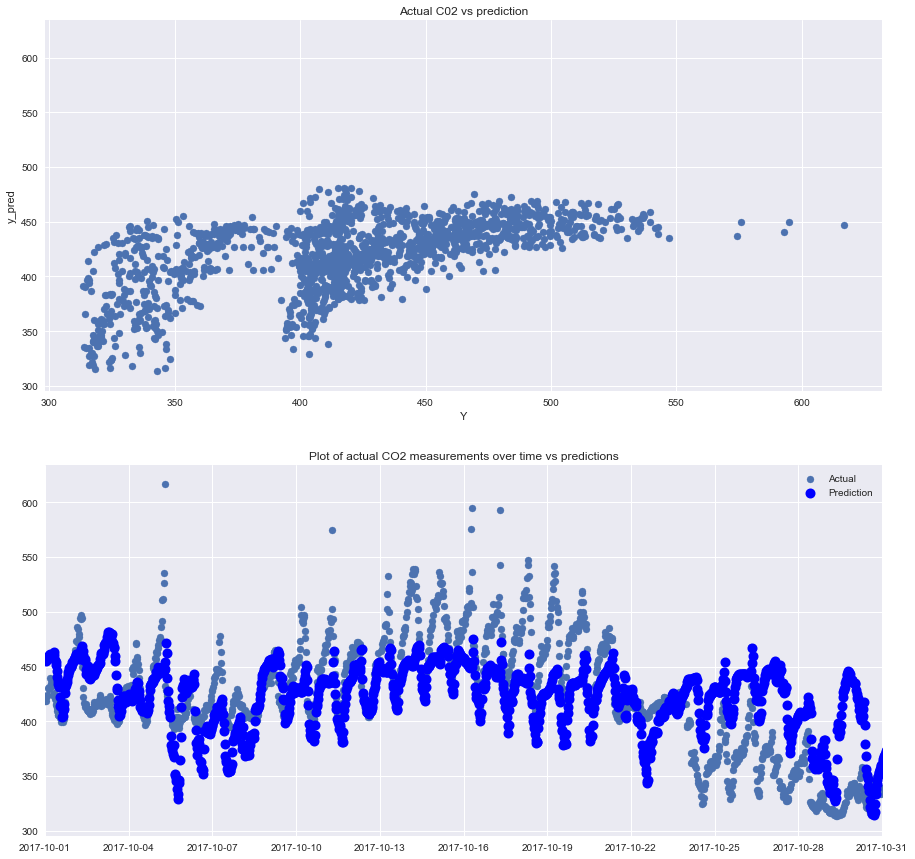

In [80]:
        f, (ax1, ax2) = plt.subplots(2, 1,figsize=(15,15),sharey=True)
        ax1.scatter(Y,y_pred)
        ax1.set_xlabel('Y')
        ax1.set_ylabel('y_pred')
        ax1.set_title('Actual C02 vs prediction')

        ax2.scatter(list(X.index),Y,label='Actual')
        ax2.scatter(list(X.index),y_pred,color='blue', linewidth=3,label='Prediction')
        ax2.set_xlim(['2017-10-01','2017-10-31'])
        ax2.set_title('Plot of actual CO2 measurements over time vs predictions')
        ax2.legend();

### We notice that after  October 24th predictions are higher than actual measures. The expert was right.

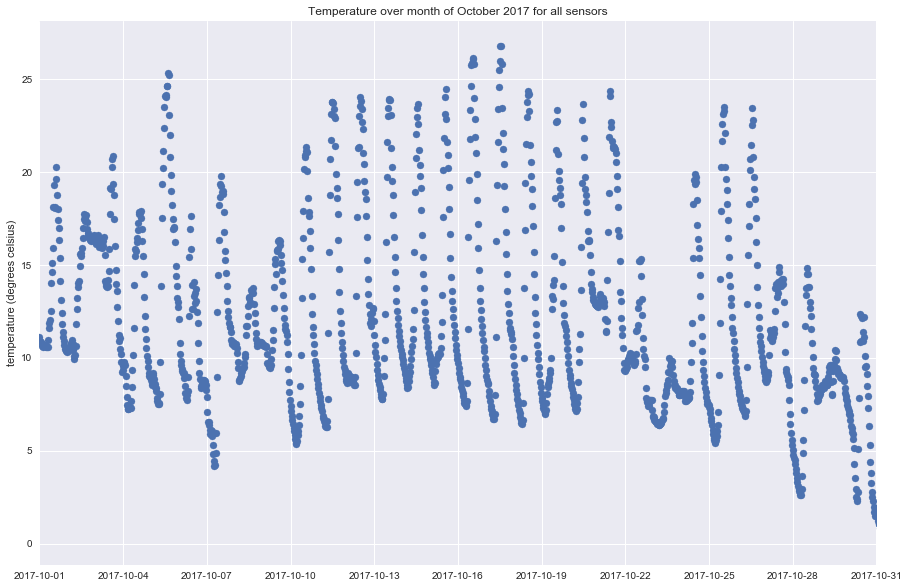

In [110]:
f,ax =plt.subplots(1,1,figsize=(15,10));
ax.scatter(list(X.index),X['temperature']);
ax.set_xlim(['2017-10-01','2017-10-31']);
ax.set_title('Temperature over month of October 2017 for all sensors');
ax.set_ylabel('temperature (degrees celsius)');

### We notice a sudden fall of temperature at the end of October wich leads in a CO2 decrease. 

### Question III.b. (8/15)

In your next attempt to find the problem, you decide to use the temporal and altitude clusters computed in PART II, together with the zone clusters of the city that are already provided, to improve your model. 

First, find the sensors belonging to the same zone and altitude cluster. Keep only the part of the dataframe from Part I.a that matches the same zone and altitude cluster with `ZSBN`.

Then, partition the obtained dataframe into six parts, each corresponding to one of the wind clusters.  

Use the partitioned dataframes to learn a new regression model for each of them. For each linear model, use as features 1) the temperature, 2) the humidity, and 3) the time of the day measured in the range between 0 and 47 (intervals of 30 min). At the end of this step, you should have obtained a simple linear regression model for each wind cluster.

Finally, plot and compare the actual CO2 measurements, and the values obtained by the linear model for the entire month of October. If all the steps are done correcly, you should be able to clearly detect the drift observed after October 26th.

Here we filter to have the sensors that are in the same zone and altitude cluster than 'ZSBN':

In [81]:
c1 = clust[clust['LocationName']=='ZSBN']
c2 = clust[clust['zone']==c1['zone'].iloc[0]]
c3 = c2[c2['alt_c']==c1['alt_c'].iloc[0]]

In [82]:
c3.head()# We see that 4 sensors match

,LocationName,zone,altitude,alt_c
26,ZHRG,3.0,410.5,0
28,ZHRZ,3.0,429.5,0
36,ZSBN,3.0,415.4,0
44,ZUE,3.0,408.8,0


In [83]:
Final.head()#From I.a

,LocationName,SensorUnit_ID,CO2,temperature,humidity
timestamp,,,,,
2017-10-01 00:00:00,ZGHD,1014.0,595.004391,11.396667,92.440806
2017-10-01 00:30:00,ZGHD,1014.0,597.017879,11.303333,91.625097
2017-10-01 01:00:00,ZGHD,1014.0,596.487010,11.240000,91.096761
2017-10-01 01:30:00,ZGHD,1014.0,598.787639,11.260000,91.275734
2017-10-01 02:00:00,ZGHD,1014.0,595.366394,11.285000,91.003937


In [84]:
#Condition on the four locations 
ret=(Final['LocationName']=='ZHRG')|(Final['LocationName']=='ZHRZ')|(Final['LocationName']=='ZSBN')|(Final['LocationName']=='ZUE')

In [85]:
Final[ret]['LocationName'].unique()#We verify that our condtionning worked

array(['ZHRG', 'ZUE', 'ZSBN', 'ZHRZ'], dtype=object)

In [86]:
Final2 = Final[ret].copy()

Here we map to our condtionned dataset day, time and wind cluster:

In [87]:
Final2 = Final2.reset_index()
Final2.head()
Final2['day'] = Final2['timestamp'].dt.day
Final2['time'] = Final2['timestamp'].dt.time
Final2['wind_clust'] = Final2['day'].map(sr)
s = Final2['timestamp'].dt.time.iloc[0:48]
s2 = pd.Series(data=s.index,index=s)
Final2['hour'] = Final2['time'].map(s2)
Final2.head()

,timestamp,LocationName,SensorUnit_ID,CO2,temperature,humidity,day,time,wind_clust,hour
0,2017-10-01 00:00:00,ZHRG,1017.0,425.095878,11.040000,89.914205,1,00:00:00,5,0
1,2017-10-01 00:30:00,ZHRG,1017.0,424.306724,10.960000,89.787048,1,00:30:00,5,1
2,2017-10-01 01:00:00,ZHRG,1017.0,426.618723,10.980000,89.294952,1,01:00:00,5,2
3,2017-10-01 01:30:00,ZHRG,1017.0,430.540983,10.993333,89.351537,1,01:30:00,5,3
4,2017-10-01 02:00:00,ZHRG,1017.0,428.007043,11.033333,89.207850,1,02:00:00,5,4


Eventually, we can extract each observation per wind cluster:

In [88]:
g = Final2.groupby('wind_clust')
g0 = g.get_group(0)
g1 = g.get_group(1)
g2 = g.get_group(2)
g3 = g.get_group(3)
g4 = g.get_group(4)
g5 = g.get_group(5)

In the following function, we run the regression on each wind cluster and we plot the predicted CO2 values vs the actuals.

In [89]:
def plot_reg(g_number=None,all=False):
    
    if (all==True):
        f, ax = plt.subplots(1, 1,figsize=(18,10))
        k=0
        colors=['blue','red','green','black','brown','grey']
        for i  in [g0,g1,g2,g3,g4,g5]:
           
            X = i[['temperature','humidity','hour']]
            Y = i['CO2']
            linreg  = LinearRegression()
            linreg.fit(X,Y)
            y_pred = linreg.predict(X)
            
            ax.scatter(list(i['timestamp']),Y,label='CO2 for wind cluster # %d' %(k),color=colors[k])
            if (k==5):
                ax.scatter(list(i['timestamp']),y_pred,color='yellow', linewidth=1,label='C02 prediction')
            else:
                ax.scatter(list(i['timestamp']),y_pred,color='yellow', linewidth=1)
            ax.set_xlim(['2017-10-01','2017-10-31'])
            ax.set_title('Plot of actual CO2 measurements over time vs predictions')
            ax.legend()
            k+=1
       
        
    else:
        X = g_number[['temperature','humidity','hour']]
        Y = g_number['CO2']
        linreg  = LinearRegression()
        linreg.fit(X,Y)
        y_pred = linreg.predict(X)
        #print('RMSE is equal to :',np.sqrt(metrics.mean_squared_error(Y,y_pred)))


        f, (ax1, ax2) = plt.subplots(2, 1,figsize=(15,15),sharey=True)
        ax1.scatter(Y,y_pred)
        ax1.set_xlabel('Y')
        ax1.set_ylabel('y_pred')
        ax1.set_title('Actual C02 vs prediction')

        ax2.scatter(list(g_number['timestamp']),Y,label='Actual')
        ax2.scatter(list(g_number['timestamp']),y_pred,color='blue', linewidth=3,label='Prediction')
        ax2.set_xlim(['2017-10-01','2017-10-31'])
        ax2.set_title('Plot of actual CO2 measurements over time vs predictions')
        ax2.legend()
        plt.show()

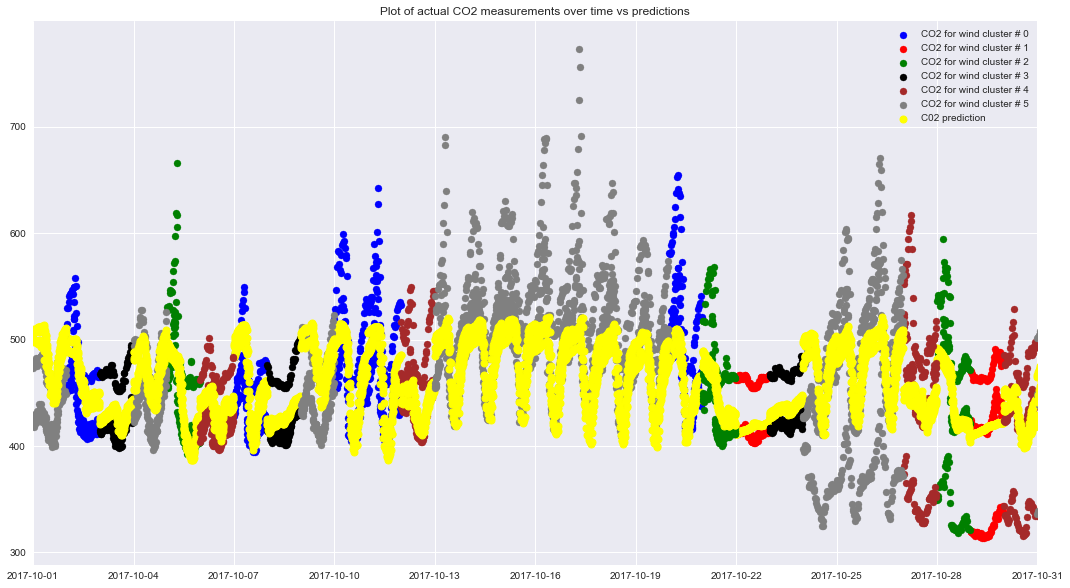

In [90]:
plot_reg(all=True)

## We now observe a drift  after October 24th like the expert said. Actual measurements are really below predictions.

### Question III.c. (2/15)

Focus on the `KBRL` site. Apply the same procedure by fitting a linear model to the days with similar wind behavior. Plot and compare the actual CO2 measurements, and the values obtained by the linear model for the entire month of October. If all the steps are done correcly, you should be able detect the outlier observed in the beginning of October. 

We repeat the same operations as before but this time for location 'KBRL':

In [91]:
c1 = clust[clust['LocationName']=='KBRL']
c2 = clust[clust['zone']==c1['zone'].iloc[0]]
c3 = c2[c2['alt_c']==c1['alt_c'].iloc[0]]

In [92]:
c3.head()

,LocationName,zone,altitude,alt_c
3,KBRL,7.0,510.5,3


We notice that 'KBRL' is the only one to match both altitude and zone clusters.

In [93]:
#Condition on the four locations 
Final3 = Final[Final['LocationName']=='ZHRG'].copy()

In [94]:
Final3 = Final3.reset_index()
Final3.head()
Final3['day'] = Final3['timestamp'].dt.day
Final3['time'] = Final3['timestamp'].dt.time
Final3['wind_clust'] = Final3['day'].map(sr)
s = Final3['timestamp'].dt.time.iloc[0:48]
s2 = pd.Series(data=s.index,index=s)
Final3['hour'] = Final3['time'].map(s2)
Final3.head()

,timestamp,LocationName,SensorUnit_ID,CO2,temperature,humidity,day,time,wind_clust,hour
0,2017-10-01 00:00:00,ZHRG,1017.0,425.095878,11.040000,89.914205,1,00:00:00,5,0
1,2017-10-01 00:30:00,ZHRG,1017.0,424.306724,10.960000,89.787048,1,00:30:00,5,1
2,2017-10-01 01:00:00,ZHRG,1017.0,426.618723,10.980000,89.294952,1,01:00:00,5,2
3,2017-10-01 01:30:00,ZHRG,1017.0,430.540983,10.993333,89.351537,1,01:30:00,5,3
4,2017-10-01 02:00:00,ZHRG,1017.0,428.007043,11.033333,89.207850,1,02:00:00,5,4


In [95]:
Final3['wind_clust'].unique()

array([5, 0, 3, 2, 4, 1])

In [96]:
g = Final3.groupby('wind_clust')
g0 = g.get_group(0)
g1 = g.get_group(1)
g2 = g.get_group(2)
g3 = g.get_group(3)
g4 = g.get_group(4)
g5 = g.get_group(5)

Let's reuse our previous fonction to plot measures vs predictions:

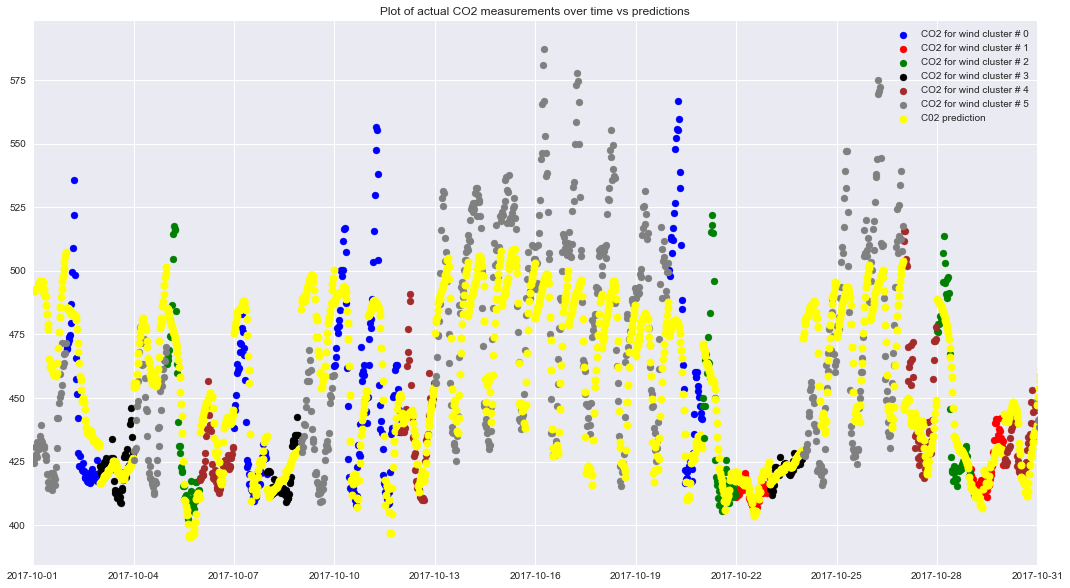

In [97]:
plot_reg(all=True)

When we look at all the predictions we seen that early october cluster 2 CO2 acutal measures are really far from predictions. Let's investigate.

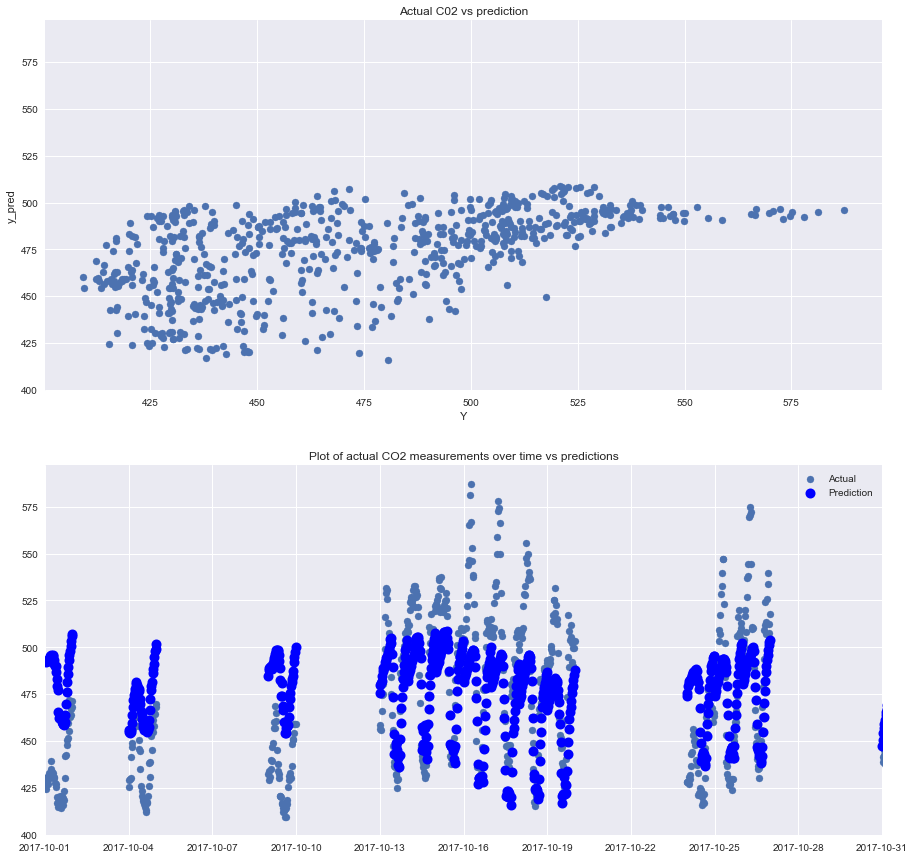

In [103]:
plot_reg(g_number=g5)

### Cluster wind #5 has the highest RMSE and when we see that predictions are really far from actual measurements for early october.

## PART IV: Share your work with the domain expert (10 points)

The domain experts would like to try out your work but they have python 2.6 installed and they
do not want to install anaconda3.
They tried to create a `Dockerfile` in order to build a Docker image and play with the notebook
but it didn't work.

Use
```bash
docker build -t co2notebook .
```
and
```bash
docker run --init --rm -it -p 8888:8888 co2notebook
```
to play with the Docker image.
More details can be found in the README file.

Notice how the notebook opens but that the first code cell cannot be executed.
```
---------------------------------------------------------------------------
ModuleNotFoundError                       Traceback (most recent call last)
[...]
```

### Question IV.a. (10/10)

Edit the `Dockerfile` so that you can execute the whole notebook from the `docker run` command.
This means that all the cells should run, not just the first one.

While this task can be completed by minor modifications, you are free to edit any part of the `Dockerfile`.

For a complete read over how a `Dockerfile` works, head to https://docs.docker.com/engine/reference/builder/.